In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastbook import *

In [3]:
import cv2
import os

In [4]:
root_dir = "../data/usq/"

In [229]:
def create_MIP(np_img, slices_num = 15):
    ''' create the mip image from original image, slice_num is the number of 
    slices for maximum intensity projection'''
    img_shape = np_img.shape
    np_mip = np.zeros(img_shape)
    for i in range(img_shape[0]):
        start = max(0, i-slices_num)
        np_mip[i,:,:] = np.amax(np_img[start:i+1],0)
    return np_mip

In [6]:
def save_images(img_dir, file_list, img_3d_array):
    for i in range(img_3d_array.shape[0]):
        cv2.imwrite(os.path.join(img_dir, file_list[i]), img_3d_array[i, :, :])

In [170]:
def create_black_image (h, w):
    # initialise black image with zeros and return result
    return np.zeros((h,w), np.uint16)

def get_filenames (pathname, ext):
    list_of_filenames = []
    for (dirpath, dirnames, filenames) in os.walk(pathname):
        for f in filenames:
            if f.endswith(ext): # just pick images with the correct extension
                list_of_filenames.append(f)

    # sort the files by the numbers in their filenames 
    list_of_filenames.sort()
    return list_of_filenames

def convert_image_to_grey(image,h,w):
    # grab the image dimensions
    grey_image = create_black_image(h,w)
    grey_image[:h,:w] = image[:,:,0]
    # return the grey image (with a single colour channel)
    return grey_image

def load_images (pathname,ext,d,h,w): 
    lf   = get_filenames (pathname,ext)
    limg = np.ndarray(shape=(d,h,w), dtype=np.uint16)
    i=0
    for f in lf: 
        img = cv2.imread(pathname+"/"+f)
        # convert image to grey 
        img = convert_image_to_grey(img,h,w)
        limg[i]=img
        i=i+1
    return limg 

In [7]:
# k's custom
def load_images (img_dir, file_list, d, h, w): 
    limg = np.ndarray(shape=(d, h, w), dtype=np.uint16)
    i=0
    for f in file_list: 
        img = cv2.imread(os.path.join(img_dir, f))
        limg[i]=img[:,:,0] 
        i=i+1
    return limg 

In [8]:
def convert_3d_mip(parent_dir, omit, source_dir = 'original_mra', target_dir = 'mra_mip'):
    #do images
    for subdir in os.listdir(os.path.join(parent_dir, source_dir)):
        # leave out MRI for test
        if subdir in omit:
            continue
        full_img_subdir = os.path.join(parent_dir, source_dir, subdir)
        fnames = os.listdir(full_img_subdir)
        img_3d = load_images(full_img_subdir, fnames, len(fnames), 320, 320)
        img_mip = create_MIP(img_3d, slices_num = img_3d.shape[0])
        # create target dir
        tgt_dir =  os.path.join(parent_dir, target_dir, subdir)
        os.makedirs(tgt_dir, exist_ok=True)
        save_images(tgt_dir, fnames, img_mip)    

In [9]:
# this function grabs images/masks from different patient subdirectories and consolidates 
# them into a single folder with consistent naming
def combine(parent_dir, image_src, image_tgt, mask_src, mask_tgt):
    image_srcdir = os.path.join(parent_dir, image_src)
    mask_srcdir = os.path.join(parent_dir, mask_src)
    image_tgtdir = os.path.join(parent_dir, image_tgt)
    mask_tgtdir = os.path.join(parent_dir, mask_tgt)  
    
    os.makedirs(image_tgtdir, exist_ok=True)
    os.makedirs(mask_tgtdir, exist_ok=True)
    
    for subdir in os.scandir(image_srcdir):
        image_list = sorted(os.listdir(subdir))
        mask_list = sorted(os.listdir(os.path.join(mask_srcdir, os.path.basename(subdir))))
        for i in range(len(image_list)):
            if image_list[i].endswith('.jpg'):
                shutil.copy(os.path.join(subdir.path, image_list[i]), os.path.join(image_tgtdir, image_list[i])) 
                shutil.copy(os.path.join(os.path.join(mask_srcdir, os.path.basename(subdir)), mask_list[i]), os.path.join(mask_tgtdir, image_list[i]))

In [19]:
# convert_3d_mip(root_dir, 'original_mra', 'mra_mip')
# convert_3d_mip(root_dir, 'manual_segmentation',  'mask_mip')

In [28]:
train_list = ['MNI_0590', 'MNI_0591', 'MNI_0592', 'MNI_0640', 'MNI_0643', 'MNI_0648', 'MNI_0656', 'MNI_0657', 'MNI_0663']
test_list = ['MNI_0664']

In [29]:
# do training run
convert_3d_mip(root_dir, test_list, 'original_mra', 'train_mra_mip')
convert_3d_mip(root_dir, test_list, 'manual_segmentation',  'train_mask_mip')
# apply to test set
convert_3d_mip(root_dir, train_list, 'original_mra', 'test_mra_mip')
convert_3d_mip(root_dir, train_list, 'manual_segmentation',  'test_mask_mip')
# put together in train/test folders with consistent naming for image/mask
combine(root_dir, 'train_mra_mip', 'train/images', 'train_mask_mip', 'train/masks')
combine(root_dir, 'test_mra_mip', 'test/images', 'test_mask_mip', 'test/masks')

In [54]:
# one off

In [53]:
def combine(parent_dir, image_src, image_tgt, mask_src, mask_tgt, mra):
    image_srcdir = os.path.join(parent_dir, image_src)
    mask_srcdir = os.path.join(parent_dir, mask_src)
    #image_tgtdir = os.path.join(parent_dir, image_tgt, mra, 'images')
    #mask_tgtdir = os.path.join(parent_dir, mask_tgt, mra, 'masks')  
    image_tgtdir = os.path.join(parent_dir, image_tgt)
    mask_tgtdir = os.path.join(parent_dir, mask_tgt)
    os.makedirs(image_tgtdir, exist_ok=True)
    os.makedirs(mask_tgtdir, exist_ok=True)
    image_list = sorted(os.listdir(os.path.join(image_srcdir, mra)))
    mask_list = sorted(os.listdir(os.path.join(mask_srcdir, os.path.basename(mra))))
    for i in range(len(image_list)):
        if image_list[i].endswith('.jpg'):
            print(f'copying {os.path.join(image_srcdir, mra, image_list[i])} to {os.path.join(image_tgtdir, image_list[i])}')

            shutil.copy(os.path.join(image_srcdir, mra, image_list[i]), os.path.join(image_tgtdir, image_list[i])) 
            shutil.copy(os.path.join(os.path.join(mask_srcdir, os.path.basename(mra)), mask_list[i]), os.path.join(mask_tgtdir, image_list[i]))

In [55]:
# run for individual
test_list = ['MNI_0590', 'MNI_0591', 'MNI_0592', 'MNI_0640', 'MNI_0643', 'MNI_0648', 'MNI_0656', 'MNI_0657', 'MNI_0663']
#test_list = ['MNI_0664']
for i in test_list:
    combine(root_dir, 'train_mra_mip', f'oneoff/{i}/images', 'train_mask_mip', f'oneoff/{i}/masks', i)

copying ../data/usq/train_mra_mip/MNI_0590/S580900000.jpg to ../data/usq/oneoff/MNI_0590/images/S580900000.jpg
copying ../data/usq/train_mra_mip/MNI_0590/S580900001.jpg to ../data/usq/oneoff/MNI_0590/images/S580900001.jpg
copying ../data/usq/train_mra_mip/MNI_0590/S580900002.jpg to ../data/usq/oneoff/MNI_0590/images/S580900002.jpg
copying ../data/usq/train_mra_mip/MNI_0590/S580900003.jpg to ../data/usq/oneoff/MNI_0590/images/S580900003.jpg
copying ../data/usq/train_mra_mip/MNI_0590/S580900004.jpg to ../data/usq/oneoff/MNI_0590/images/S580900004.jpg
copying ../data/usq/train_mra_mip/MNI_0590/S580900005.jpg to ../data/usq/oneoff/MNI_0590/images/S580900005.jpg
copying ../data/usq/train_mra_mip/MNI_0590/S580900006.jpg to ../data/usq/oneoff/MNI_0590/images/S580900006.jpg
copying ../data/usq/train_mra_mip/MNI_0590/S580900007.jpg to ../data/usq/oneoff/MNI_0590/images/S580900007.jpg
copying ../data/usq/train_mra_mip/MNI_0590/S580900008.jpg to ../data/usq/oneoff/MNI_0590/images/S580900008.jpg
c

copying ../data/usq/train_mra_mip/MNI_0591/S580960181.jpg to ../data/usq/oneoff/MNI_0591/images/S580960181.jpg
copying ../data/usq/train_mra_mip/MNI_0591/S580960182.jpg to ../data/usq/oneoff/MNI_0591/images/S580960182.jpg
copying ../data/usq/train_mra_mip/MNI_0591/S580960183.jpg to ../data/usq/oneoff/MNI_0591/images/S580960183.jpg
copying ../data/usq/train_mra_mip/MNI_0591/S580960184.jpg to ../data/usq/oneoff/MNI_0591/images/S580960184.jpg
copying ../data/usq/train_mra_mip/MNI_0591/S580960185.jpg to ../data/usq/oneoff/MNI_0591/images/S580960185.jpg
copying ../data/usq/train_mra_mip/MNI_0591/S580960186.jpg to ../data/usq/oneoff/MNI_0591/images/S580960186.jpg
copying ../data/usq/train_mra_mip/MNI_0591/S580960187.jpg to ../data/usq/oneoff/MNI_0591/images/S580960187.jpg
copying ../data/usq/train_mra_mip/MNI_0591/S580960188.jpg to ../data/usq/oneoff/MNI_0591/images/S580960188.jpg
copying ../data/usq/train_mra_mip/MNI_0591/S580960189.jpg to ../data/usq/oneoff/MNI_0591/images/S580960189.jpg
c

copying ../data/usq/train_mra_mip/MNI_0640/S572920117.jpg to ../data/usq/oneoff/MNI_0640/images/S572920117.jpg
copying ../data/usq/train_mra_mip/MNI_0640/S572920118.jpg to ../data/usq/oneoff/MNI_0640/images/S572920118.jpg
copying ../data/usq/train_mra_mip/MNI_0640/S572920119.jpg to ../data/usq/oneoff/MNI_0640/images/S572920119.jpg
copying ../data/usq/train_mra_mip/MNI_0640/S572920120.jpg to ../data/usq/oneoff/MNI_0640/images/S572920120.jpg
copying ../data/usq/train_mra_mip/MNI_0640/S572920121.jpg to ../data/usq/oneoff/MNI_0640/images/S572920121.jpg
copying ../data/usq/train_mra_mip/MNI_0640/S572920122.jpg to ../data/usq/oneoff/MNI_0640/images/S572920122.jpg
copying ../data/usq/train_mra_mip/MNI_0640/S572920123.jpg to ../data/usq/oneoff/MNI_0640/images/S572920123.jpg
copying ../data/usq/train_mra_mip/MNI_0640/S572920124.jpg to ../data/usq/oneoff/MNI_0640/images/S572920124.jpg
copying ../data/usq/train_mra_mip/MNI_0640/S572920125.jpg to ../data/usq/oneoff/MNI_0640/images/S572920125.jpg
c

copying ../data/usq/train_mra_mip/MNI_0648/S574110075.jpg to ../data/usq/oneoff/MNI_0648/images/S574110075.jpg
copying ../data/usq/train_mra_mip/MNI_0648/S574110076.jpg to ../data/usq/oneoff/MNI_0648/images/S574110076.jpg
copying ../data/usq/train_mra_mip/MNI_0648/S574110077.jpg to ../data/usq/oneoff/MNI_0648/images/S574110077.jpg
copying ../data/usq/train_mra_mip/MNI_0648/S574110078.jpg to ../data/usq/oneoff/MNI_0648/images/S574110078.jpg
copying ../data/usq/train_mra_mip/MNI_0648/S574110079.jpg to ../data/usq/oneoff/MNI_0648/images/S574110079.jpg
copying ../data/usq/train_mra_mip/MNI_0648/S574110080.jpg to ../data/usq/oneoff/MNI_0648/images/S574110080.jpg
copying ../data/usq/train_mra_mip/MNI_0648/S574110081.jpg to ../data/usq/oneoff/MNI_0648/images/S574110081.jpg
copying ../data/usq/train_mra_mip/MNI_0648/S574110082.jpg to ../data/usq/oneoff/MNI_0648/images/S574110082.jpg
copying ../data/usq/train_mra_mip/MNI_0648/S574110083.jpg to ../data/usq/oneoff/MNI_0648/images/S574110083.jpg
c

copying ../data/usq/train_mra_mip/MNI_0657/S571730031.jpg to ../data/usq/oneoff/MNI_0657/images/S571730031.jpg
copying ../data/usq/train_mra_mip/MNI_0657/S571730032.jpg to ../data/usq/oneoff/MNI_0657/images/S571730032.jpg
copying ../data/usq/train_mra_mip/MNI_0657/S571730033.jpg to ../data/usq/oneoff/MNI_0657/images/S571730033.jpg
copying ../data/usq/train_mra_mip/MNI_0657/S571730034.jpg to ../data/usq/oneoff/MNI_0657/images/S571730034.jpg
copying ../data/usq/train_mra_mip/MNI_0657/S571730035.jpg to ../data/usq/oneoff/MNI_0657/images/S571730035.jpg
copying ../data/usq/train_mra_mip/MNI_0657/S571730036.jpg to ../data/usq/oneoff/MNI_0657/images/S571730036.jpg
copying ../data/usq/train_mra_mip/MNI_0657/S571730037.jpg to ../data/usq/oneoff/MNI_0657/images/S571730037.jpg
copying ../data/usq/train_mra_mip/MNI_0657/S571730038.jpg to ../data/usq/oneoff/MNI_0657/images/S571730038.jpg
copying ../data/usq/train_mra_mip/MNI_0657/S571730039.jpg to ../data/usq/oneoff/MNI_0657/images/S571730039.jpg
c

copying ../data/usq/train_mra_mip/MNI_0663/S572080186.jpg to ../data/usq/oneoff/MNI_0663/images/S572080186.jpg
copying ../data/usq/train_mra_mip/MNI_0663/S572080187.jpg to ../data/usq/oneoff/MNI_0663/images/S572080187.jpg
copying ../data/usq/train_mra_mip/MNI_0663/S572080188.jpg to ../data/usq/oneoff/MNI_0663/images/S572080188.jpg
copying ../data/usq/train_mra_mip/MNI_0663/S572080189.jpg to ../data/usq/oneoff/MNI_0663/images/S572080189.jpg
copying ../data/usq/train_mra_mip/MNI_0663/S572080190.jpg to ../data/usq/oneoff/MNI_0663/images/S572080190.jpg
copying ../data/usq/train_mra_mip/MNI_0663/S572080191.jpg to ../data/usq/oneoff/MNI_0663/images/S572080191.jpg
copying ../data/usq/train_mra_mip/MNI_0663/S572080192.jpg to ../data/usq/oneoff/MNI_0663/images/S572080192.jpg
copying ../data/usq/train_mra_mip/MNI_0663/S572080193.jpg to ../data/usq/oneoff/MNI_0663/images/S572080193.jpg
copying ../data/usq/train_mra_mip/MNI_0663/S572080194.jpg to ../data/usq/oneoff/MNI_0663/images/S572080194.jpg
c

In [42]:
train_list = ['MNI_0590', 'MNI_0591', 'MNI_0592', 'MNI_0640', 'MNI_0643', 'MNI_0648', 'MNI_0656', 'MNI_0657', 'MNI_0663']
test_list = ['MNI_0664']

In [259]:
## new projections

In [208]:
imgnames = os.listdir('../data/usq/original_mra/MNI_0590')
msknames = os.listdir('../data/usq/manual_segmentation/MNI_0590')

#img_3d = load_images('../data/usq/original_mra/MNI_0590', imgnames, len(imgnames), 320, 320)
#msk_3d = load_images('../data/usq/manual_segmentation/MNI_0590', msknames, len(msknames), 320, 320)
img_3d = load_images('../data/usq/original_mra/MNI_0590', 'jpg', len(imgnames), 320, 320)
msk_3d = load_images('../data/usq/manual_segmentation/MNI_0590', 'jpg', len(msknames), 320, 320)

In [249]:
_3d_img = img_3d
d = 247
h = 320
w = 320
black_box = np.zeros((d, h + w - 1, h + w - 1), np.uint16)
for i in range(h):
    for j in range(w): 
        if j - i < w + 1:
            black_box[:, h + (j - i) - 1, i + j] = _3d_img[:, i, j]
        else: 
            black_box[:, h + w - (j - i) - 1, i + j] = _3d_img[:, i, j]

In [230]:
black_box_mip = create_MIP(black_box, 247)

In [250]:
black_box2 = np.zeros((w, d + h - 1, d + h - 1), np.uint16)
for i in range(d):
    for j in range(h): 
        if j - i < h + 1:
            black_box2[:, d + (j - i) - 1, i + j] = _3d_img[i, j, :]
        else: 
            black_box2[:, d + h - (j - i) - 1, i + j] = _3d_img[i, j, :]

In [254]:
m1 = np.rot90(img_3d, axes=(0,1))
m2 = np.rot90(img_3d, axes=(1,2))
m3 = np.rot90(img_3d, axes=(0,2))

In [111]:
def create_black_image (h, w):
    # initialise black image with zeros and return result
    return np.zeros((h,w), np.uint16)

In [182]:
#-----------------------------------
# Author:      Rudiger von Hackewitz 
# Date:        December 2018 
# 
# Running the 2D image projections 


import numpy as np
#from utils.support import create_black_image
import cv2

class MRAProjection():
    def __init__(self, ThreeDImg):
        self._3d_img = ThreeDImg
        
        self._d = ThreeDImg.shape[0]
        self._h = ThreeDImg.shape[1]
        self._w = ThreeDImg.shape[2]
        print(f'd: {ThreeDImg.shape[0]}, h: {ThreeDImg.shape[1]}, w:{ThreeDImg.shape[2]}')
        # build up image directory with image projections and CLAHE enhancements 
        self._img_projs = dict()
  
    
    # CLAHE-enhance the image projections 
    def do_clahe(self, img): 
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        output = clahe.apply(img.astype(np.uint8))
        return output.astype(np.uint16)
       
            
            
    def run_projections(self): 

        # 1st Projection 
        smax1  = np.amax(self._3d_img, axis=0)
        out1   = self.do_clahe(smax1)
        self._img_projs[1] = [smax1, out1]

        # 2nd Projection 
        smax2  = np.amax(self._3d_img, axis=1)
        out2   = self.do_clahe(smax2)
        self._img_projs[2] = [smax2, out2]

        # 3rd Projection 
        smax3  = np.amax(self._3d_img, axis=2)
        out3   = self.do_clahe(smax3)
        self._img_projs[3] = [smax3, out3]
        
        #################################
        # Now we run the edge projections 
        #################################
        
        black_box = np.zeros((self._d,self._h + self._w - 1,self._h + self._w - 1), np.uint16)
        for i in range(self._h):
            for j in range(self._w): 
                if j-i < self._w+1:
                    black_box[:,self._h+(j-i)-1,i+j] = self._3d_img[:,i,j]
                else: 
                    black_box[:,self._h+self._w-(j-i)-1,i+j] = self._3d_img[:,i,j]
        
        # Projection 4
        smax4  = np.amax(black_box, axis=1)
        out4   = self.do_clahe(smax4)
        self._img_projs[4] = [smax4, out4]
        
        # Projection 5
        smax5  = np.amax(black_box, axis=2)
        out5   = self.do_clahe(smax5)
        self._img_projs[5] = [smax5, out5]
        
        
        black_box = np.zeros((self._h,self._w+self._d-1,self._w+self._d-1), np.uint16)
        for i in range(self._d):
            for j in range(self._w): 
                if j-i < self._w+1:
                    black_box[:,self._d+(j-i)-1,i+j] = self._3d_img[i,:,j]
                else: 
                    black_box[:,self._d+self._w-(j-i)-1,i+j] = self._3d_img[i,:,j]
            
        # Projection 6
        smax6  = np.amax(black_box, axis=1)
        out6   = self.do_clahe(smax6)
        self._img_projs[6] = [smax6, out6]
        
        # Projection 7
        smax7  = np.amax(black_box, axis=2)
        out7   = self.do_clahe(smax7)
        self._img_projs[7] = [smax7, out7]
       
        
        black_box = np.zeros((self._w,self._d + self._h - 1,self._d + self._h - 1), np.uint16)
        for i in range(self._d):
            for j in range(self._h): 
                if j-i < self._h+1:
                    black_box[:,self._d+(j-i)-1,i+j] = self._3d_img[i,j,:]
                else: 
                    black_box[:,self._d+self._h-(j-i)-1,i+j] = self._3d_img[i,j,:]
     
        # Projection 8
        smax8  = np.amax(black_box, axis=1)
        out8   = self.do_clahe(smax8)
        self._img_projs[8] = [smax8, out8]
        
        # Projection 9
        smax9  = np.amax(black_box, axis=2)
        out9   = self.do_clahe(smax9)
        self._img_projs[9] = [smax9, out9]
       


    def reconstruct3DMRA(self, so_img_p): # 12 seconds 
        # initialise empty 3D 'black box' that will be segmented in the process below 
        black_box = np.zeros(shape=(self._d,self._h,self._w), dtype=np.uint16) 

        # Projection 1 
        p=0
        ix = np.equal(so_img_p[p], 1)
        idx = np.where(ix)
        # list of indices that flag blood vessel locations 
        indices = list(zip(idx[0],idx[1]))

        for idx in indices:
            y = idx[0]
            z = idx[1]
            max_val = np.max(self._3d_img[:,y,z])
            for i in np.where(np.greater_equal(self._3d_img[:,y,z], max_val))[0]:
                black_box[i,y,z] = black_box[i,y,z] + 1
        
        
        # Projection 2 
        p=1
        iy = np.equal(so_img_p[p], 1)
        idy = np.where(iy)
        # list of indices that flag blood vessel locations 
        indices = list(zip(idy[0],idy[1]))

        for idy in indices:
            x = idy[0]
            z = idy[1]
            max_val = np.max(self._3d_img[x,:,z])
            for i in np.where(np.greater_equal(self._3d_img[x,:,z], max_val))[0]:
                black_box[x,i,z]= black_box[x,i,z] + 1

        # Projection 3
        p=2
        iz = np.equal(so_img_p[p], 1)
        idz = np.where(iz)
        # list of indices that flag blood vessel locations 
        indices = list(zip(idz[0],idz[1]))

        for idz in indices:
            x = idz[0]
            y = idz[1]
            max_val = np.max(self._3d_img[x,y,:])
            for i in np.where(np.greater_equal(self._3d_img[x,y,:], max_val))[0]:
                black_box[x,y,i]= black_box[x,y,i] + 1

        # Projection 4      
        p=3
        xd = self._d
        yd = self._h + self._w - 1

        tilted_src = np.zeros((xd,yd,yd), np.uint16)
        tilted_blk = np.zeros((xd,yd,yd), np.uint16)

        for i in range(self._h):
            for j in range(self._w): 
                if j-i < self._w+1:
                    tilted_src[:,self._h+(j-i)-1,i+j] = self._3d_img[:,i,j]
                    tilted_blk[:,self._h+(j-i)-1,i+j] = black_box[:,i,j]
                else: 
                    tilted_src[:,self._h+self._w-(j-i)-1,i+j] = self._3d_img[:,i,j]
                    tilted_blk[:,self._h+self._w-(j-i)-1,i+j] = black_box[:,i,j]

        ix = np.equal(so_img_p[p], 1)
        idx = np.where(ix)
        for idx in list(zip(idx[0],idx[1])):
            x = idx[0]
            y = idx[1]
            max_val = np.max(tilted_src[x,:,y])
            for i in np.where(np.greater_equal(tilted_src[x,:,y], max_val))[0]:
                tilted_blk[x,i,y] = tilted_blk[x,i,y] + 1
        
        # Projection 5 
        p=4
        ix = np.equal(so_img_p[p], 1)
        idx = np.where(ix)
        for idx in list(zip(idx[0],idx[1])):
            x = idx[0]
            y = idx[1]
            max_val = np.max(tilted_src[x,y,:])
            for i in np.where(np.greater_equal(tilted_src[x,y,:], max_val))[0]:
                tilted_blk[x,y,i] = tilted_blk[x,y,i] + 1

        for i in range(self._h):
            for j in range(self._w): 
                if j-i < self._w+1:
                    black_box[:,i,j] = tilted_blk[:,self._h+(j-i)-1,i+j] 
                else: 
                    black_box[:,i,j] = tilted_blk[:,self._h+self._w-(j-i)-1,i+j] 
             
        # Projection 6      
        p=5
        xd = self._h
        yd = self._w + self._d - 1

        tilted_src = np.zeros((xd,yd,yd), np.uint16)
        tilted_blk = np.zeros((xd,yd,yd), np.uint16)

        for i in range(self._d):
            for j in range(self._w): 
                if j-i < self._w+1:
                    tilted_src[:,self._d+(j-i)-1,i+j] = self._3d_img[i,:,j]
                    tilted_blk[:,self._d+(j-i)-1,i+j] = black_box[i,:,j]
                else: 
                    tilted_src[:,self._d+self._w-(j-i)-1,i+j] = self._3d_img[i,:,j]
                    tilted_blk[:,self._d+self._w-(j-i)-1,i+j] = black_box[i,:,j]

        ix = np.equal(so_img_p[p], 1)
        idx = np.where(ix)
        for idx in list(zip(idx[0],idx[1])):
            x = idx[0]
            y = idx[1]
            max_val = np.max(tilted_src[x,:,y])
            for i in np.where(np.greater_equal(tilted_src[x,:,y], max_val))[0]:
                tilted_blk[x,i,y] = tilted_blk[x,i,y] + 1
        
        # Projection 7
        p=6
        ix = np.equal(so_img_p[p], 1)
        idx = np.where(ix)
        for idx in list(zip(idx[0],idx[1])):
            x = idx[0]
            y = idx[1]
            max_val = np.max(tilted_src[x,y,:])
            for i in np.where(np.greater_equal(tilted_src[x,y,:], max_val))[0]:
                tilted_blk[x,y,i] = tilted_blk[x,y,i] + 1

        for i in range(self._d):
            for j in range(self._w): 
                if j-i < self._w+1:
                    black_box[i,:,j] = tilted_blk[:,self._d+(j-i)-1,i+j] 
                else: 
                    black_box[i,:,j] = tilted_blk[:,self._d+self._w-(j-i)-1,i+j] 
             
     
        # Projection 8     
        p=7
        xd = self._w
        yd = self._h + self._d - 1

        tilted_src = np.zeros((xd,yd,yd), np.uint16)
        tilted_blk = np.zeros((xd,yd,yd), np.uint16)

        for i in range(self._d):
            for j in range(self._h): 
                if j-i < self._h+1:
                    tilted_src[:,self._d+(j-i)-1,i+j] = self._3d_img[i,j,:]
                    tilted_blk[:,self._d+(j-i)-1,i+j] = black_box[i,j,:]
                else: 
                    tilted_src[:,self._d+self._h-(j-i)-1,i+j] = self._3d_img[i,j,:]
                    tilted_blk[:,self._d+self._h-(j-i)-1,i+j] = black_box[i,j,:]

        ix = np.equal(so_img_p[p], 1)
        idx = np.where(ix)
        for idx in list(zip(idx[0],idx[1])):
            x = idx[0]
            y = idx[1]
            max_val = np.max(tilted_src[x,:,y])
            for i in np.where(np.greater_equal(tilted_src[x,:,y], max_val))[0]:
                tilted_blk[x,i,y] = tilted_blk[x,i,y] + 1
        
        # Projection 9
        p=8
        ix = np.equal(so_img_p[p], 1)
        idx = np.where(ix)
        for idx in list(zip(idx[0],idx[1])):
            x = idx[0]
            y = idx[1]
            max_val = np.max(tilted_src[x,y,:])
            for i in np.where(np.greater_equal(tilted_src[x,y,:], max_val))[0]:
                tilted_blk[x,y,i] = tilted_blk[x,y,i] + 1

        for i in range(self._d):
            for j in range(self._h): 
                if j-i < self._h+1:
                    black_box[i,j,:] = tilted_blk[:,self._d+(j-i)-1,i+j] 
                else: 
                    black_box[i,j,:] = tilted_blk[:,self._d+self._h-(j-i)-1,i+j] 
                                     
        return black_box        
        
 

In [184]:
msk_3d = (msk_3d > 100).astype(int) 
msk_3d = (msk_3d * 255)

In [185]:
img_projs = MRAProjection(img_3d)
msk_projs = MRAProjection(msk_3d)

d: 247, h: 320, w:320
d: 247, h: 320, w:320


In [186]:
img_projs.run_projections()
msk_projs.run_projections()

In [239]:
img_projs

In [241]:
img_3d.shape

(247, 320, 320)

In [242]:
black_box.shape

(247, 639, 639)

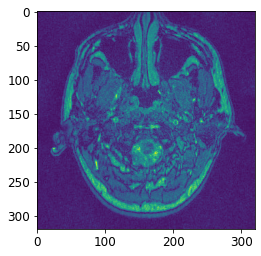

In [244]:
plt.imshow(img_3d[0])

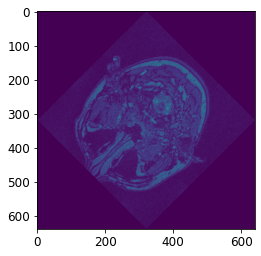

In [245]:
plt.imshow(black_box[0])